## Experiments for the course project

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, accuracy_score, recall_score, f1_score
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [2]:
x_train = pd.read_parquet('../dataset/labelencode_train.parquet')
x_train, x_test = train_test_split(x_train, train_size=0.8, test_size=0.2, shuffle=True)

In [3]:
cols = list(x_train.columns.values)
cols.remove('encounter_id')
cols.remove('diabetes_mellitus')

x_tr = x_train[cols].values
y_tr = x_train['diabetes_mellitus'].values
x_te = x_test[cols].values
y_te = x_test['diabetes_mellitus'].values

In [ ]:
tuned_parameters_dt = [{'splitter':['best', 'random'], 'max_depth': list(range(1,20)),
                        'min_samples_split':list(range(2,20)), 'min_samples_leaf':list(range(1,20)),
                        'max_leaf_nodes': list(range(2,20))}]

scores = {'f1': 'f1_macro', 'roc':'roc_auc_ovr' , 'prec': 'precision'}     

clf = RandomizedSearchCV(DecisionTreeClassifier(), tuned_parameters_dt,
                   scoring=scores, 
                   refit= "f1",
                   cv=4,
                   verbose=1,
                   n_jobs=1,
                   n_iter= 80,)

clf.fit(x_tr, y_tr)
# Validation
pred = clf.best_estimator_.predict_proba(x_te)
pred_bin = clf.best_estimator_.predict(x_te)
roc = roc_auc_score(y_te, pred[:,1])
print("ROC test split = ", roc)
print(classification_report(y_te, pred_bin, digits=4 ))
print(clf.best_params_)

In [ ]:
clf.best_params_

### Model
- decision tree

In [4]:
best_params = {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 12,
 'max_leaf_nodes': 7, 'max_depth': 5}

In [5]:
def run_experiment(model_param, attrib, attrib_list):
    pos_outcomes = {}
    for att in attrib_list:
        model_param[attrib] = att
        print(model_param)
        model = DecisionTreeClassifier(**model_param)
        model.fit(x_tr, y_tr)
        y_pred = model.predict_proba(x_te)
        pos_outcomes[att] = y_pred.copy()
#         pos_outcomes[att] = y_pred[:, 1].copy()
    return pos_outcomes

In [6]:
def draw_plot(outcomes, pos_prefix, title, file_name):
    # plot the roc curve for the model
    fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    rand_auc = [0 for _ in range(len(y_te))]
    ns_auc = roc_auc_score(y_te, rand_auc)
    print('Random: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_te, rand_auc)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

    for k, p in outcomes.items():
        # calculate scores    
        xgb_auc = roc_auc_score(y_te, p[:, 1])
        print('XGBoost %s: ROC AUC=%.3f' % (k, xgb_auc))
        acc = accuracy_score(y_te, np.argmax(p, axis=1))
        print("Accuracy %s: %.3f"% (k, acc))
        recall = recall_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("Recall %s: %.3f"% (k, recall))     
        f1 = f1_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("F1 %s: %.3f"% (k, f1))     
        
        xgb_fpr, xgb_tpr, _ = roc_curve(y_te, p[:, 1])
        pyplot.plot(xgb_fpr, xgb_tpr, label=pos_prefix+str(k))

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title(title)

    pyplot.show()
    fig.savefig(file_name)

### splitter

{'splitter': 'best', 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_leaf_nodes': 7, 'max_depth': 5}
{'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_leaf_nodes': 7, 'max_depth': 5}
Random: ROC AUC=0.500
XGBoost best: ROC AUC=0.783
Accuracy best: 0.813
Recall best: 0.321
F1 best: 0.424
XGBoost random: ROC AUC=0.754
Accuracy random: 0.804
Recall random: 0.303
F1 random: 0.399


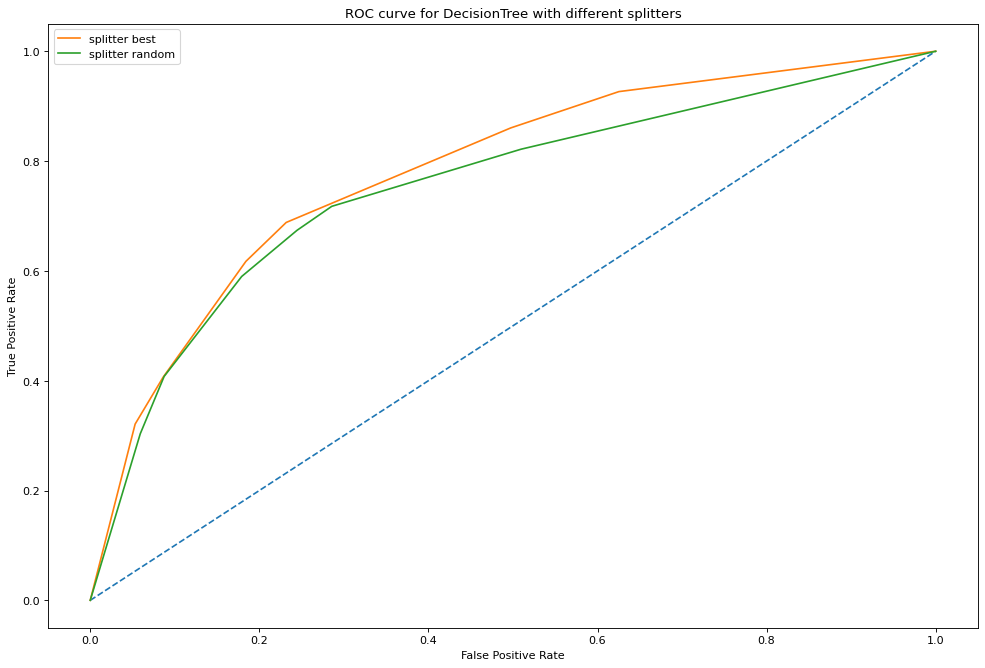

In [7]:
pos_outcomes = run_experiment(best_params, 'splitter', ['best', 'random'])
draw_plot(pos_outcomes, 'splitter ', 'ROC curve for DecisionTree with different splitters', 
          '../imgs/dt_labelencoding_splittervariations.png')

### min_sample_split

In [ ]:
pos_outcomes = run_experiment(best_params, 'min_samples_split', [3, 5, 7, 9, 11])
draw_plot(pos_outcomes, 'min_samples_split ', 'ROC curve for DecisionTree with min_samples_split range', 
          '../imgs/dt_labelencoding_min_samples_splitvariations.png')

### min_samples_leaf

In [ ]:
pos_outcomes = run_experiment(best_params, 'min_samples_leaf', [4, 6, 8, 10, 12, 14])
draw_plot(pos_outcomes, 'min_samples_leaf ', 'ROC curve for DecisionTree with min_samples_leaf range', 
          '../imgs/dt_labelencoding_min_samples_leafvariations.png')

In [ ]:
pos_outcomes = run_experiment(best_params, 'max_depth', [3, 5, 7, 9, 11])
draw_plot(pos_outcomes, 'max_depth ', 'ROC curve for DecisionTree with max_depth range', 
          '../imgs/dt_labelencoding_max_depthvariations.png')